In [1]:
from importlib import reload
import os
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.interpolate import griddata
import time
from scipy.interpolate import RegularGridInterpolator
# Set up paths for utility imports
current_dir = os.getcwd()
utilities_dir = os.path.join(current_dir, '../../utils')

# Change working directory
os.chdir(current_dir)
sys.path.insert(0, utilities_dir)

import plotting   
import importlib
importlib.reload(plotting)

<module 'plotting' from '/home/orincon/scoping-ml-wave-seismology/main/01_finite_difference_helmholtz2D/../../utils/plotting.py'>

N= 10 | Relative Error = 1.594e-01 | Time = 0.001s
N= 15 | Relative Error = 6.568e-02 | Time = 0.001s
N= 20 | Relative Error = 3.643e-02 | Time = 0.002s
N= 25 | Relative Error = 2.272e-02 | Time = 0.005s
N= 30 | Relative Error = 1.553e-02 | Time = 0.010s
N= 35 | Relative Error = 1.134e-02 | Time = 0.023s
N= 40 | Relative Error = 8.638e-03 | Time = 0.050s
N= 45 | Relative Error = 6.779e-03 | Time = 0.077s
N= 50 | Relative Error = 5.479e-03 | Time = 0.176s


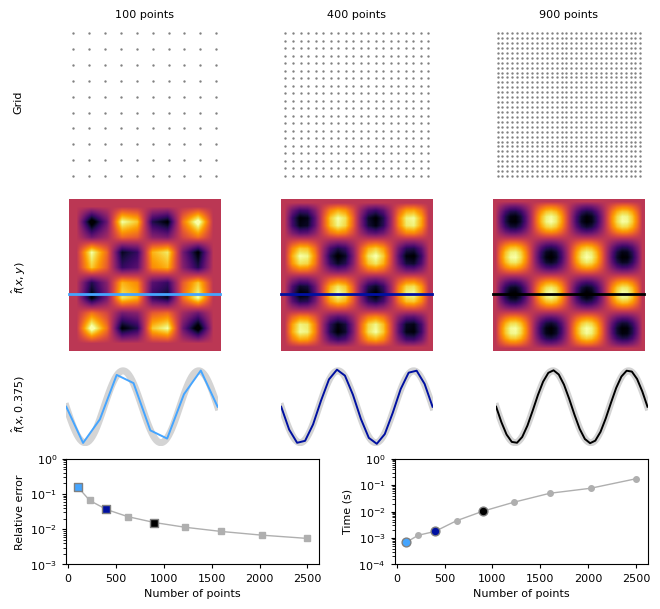

In [6]:
from importlib import reload
import os
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.interpolate import griddata
import time
from scipy.interpolate import RegularGridInterpolator
current_dir = os.getcwd()
utilities_dir = os.path.join(current_dir, '../../utils')

# Change working directory
os.chdir(current_dir)
sys.path.insert(0, utilities_dir)

import plotting   
import importlib
importlib.reload(plotting)
 
# Problem
def f_exact(x, y):
    return np.sin(4 * np.pi * x) * np.sin(4 * np.pi * y)

def rhs(x, y):
    return -2 * (4 * np.pi)**2 * np.sin(4 * np.pi * x) * np.sin(4 * np.pi * y)

# Parameters
N_values = list(range(10, 51, 5))
relative_errors = []
times = []
results = {}
n_runs = 1

# Reference mesh (100x100) for relative error
Nx_ref, Ny_ref = 100, 100
x_ref = np.linspace(0, 1, Nx_ref)
y_ref = np.linspace(0, 1, Ny_ref)
X_ref, Y_ref = np.meshgrid(x_ref, y_ref, indexing="ij")
f_exact_ref = f_exact(X_ref, Y_ref)

# Numerical solution and errors
for N in N_values:
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y, indexing='ij')
    h = x[1] - x[0]

    # Interior mask
    mask_inner = np.ones((N, N), dtype=bool)
    mask_inner[0, :] = mask_inner[-1, :] = False
    mask_inner[:, 0] = mask_inner[:, -1] = False
    inner_indices = np.argwhere(mask_inner)
    n_int = inner_indices.shape[0]

    run_times = []
    for _ in range(n_runs):
        start = time.time()

        # Construction of matrix A
        A = np.zeros((n_int, n_int))
        index_map = -np.ones((N, N), dtype=int)
        for k, (i, j) in enumerate(inner_indices):
            index_map[i, j] = k

        for k, (i, j) in enumerate(inner_indices):
            A[k, k] = -4
            for di, dj in [(-1,0), (1,0), (0,-1), (0,1)]:
                ni, nj = i + di, j + dj
                if index_map[ni, nj] != -1:
                    A[k, index_map[ni, nj]] = 1

        A /= h**2
        b = rhs(X[mask_inner], Y[mask_inner])
        f_int = np.linalg.solve(A, b)
        run_times.append(time.time() - start)

    elapsed_mean = np.mean(run_times)

    # Reconstruction of the complete solution
    f_total = np.zeros_like(X)
    f_total[mask_inner] = f_int

    # ===== Interpolation to 100x100 mesh =====
    points = np.column_stack((X.ravel(), Y.ravel()))
    values = f_total.ravel()
    f_interp = griddata(points, values, (X_ref, Y_ref), method='cubic', fill_value=0)

    # Interpolated relative error
    rel_error = np.linalg.norm(f_interp - f_exact_ref) / np.linalg.norm(f_exact_ref)

    relative_errors.append(rel_error)
    times.append(elapsed_mean)
    results[N] = (X, Y, f_total)

    print(f"N={N:3d} | Relative Error = {rel_error:.3e} | Time = {elapsed_mean:.3f}s")

# Figure

fig = plt.figure(figsize=(7.5, 7.0))
outer_gs = GridSpec(4, 1, height_ratios=[0.6, 0.6, 0.30, 0.40],
                    figure=fig, hspace=0.1)

colors = ['#45A5FF', "#0010A1", "#000000"]
N_examples = [10, 20, 30]

# Row 1: Meshes
gs_mesh = outer_gs[0].subgridspec(1, 3, wspace=0.35)
for i, N in enumerate(N_examples):
    ax = fig.add_subplot(gs_mesh[0, i])
    X, Y, _ = results[N]
    ax.scatter(X, Y, color='tab:gray', s=0.5)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")
    ax.set_title(f"{N*N} points", fontsize=8, pad=6)
fig.text(0.055, 0.77, r"Grid", fontsize=8, va="center", ha="left", rotation=90)

# Row 2: 2D contours
gs_top = outer_gs[1].subgridspec(1, 3, wspace=0.35, hspace=0.00)
for i, (N, color) in enumerate(zip(N_examples, colors)):
    ax = fig.add_subplot(gs_top[0, i])
    X, Y, F = results[N]
    cf = ax.imshow(
        F.T,
        extent=(0, 1, 0, 1),
        cmap="inferno",
        vmin=-1,
        vmax=1,
        interpolation="bilinear",
        origin="lower",
    )
    border_mask = (X == 0) | (X == 1) | (Y == 0) | (Y == 1)
    y_line = 0.375
    ax.plot(X[:, 0], np.full_like(X[:, 0], y_line), color=color, lw=2, zorder=3)
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

fig.text(0.05, 0.52, r"$\hat{f}(x,y)$", fontsize=8, va="center", ha="left", rotation=90)

# Row 3: 1D slices
gs_mid = outer_gs[2].subgridspec(1, 3, wspace=0.42, hspace=0.00)

for i, (N, color) in enumerate(zip(N_examples, colors)):
    ax = fig.add_subplot(gs_mid[0, i])
    X, Y, F = results[N]
    idx_mid = np.argmin(np.abs(Y[0, :] - 0.375))
    x_line = X[:, idx_mid]

    # Solución analítica (evaluada en 100 puntos)
    x_dense = np.linspace(0, 1, 100)
    y_dense = np.full_like(x_dense, 0.375)
    f_true_dense = f_exact(x_dense, y_dense)
    ax.plot(x_dense, f_true_dense, '-', color="#D4D4D4", lw=5.0, label="Analítico")

    # Predicción numérica (PINN)
    ax.plot(x_line, F[:, idx_mid], '-', color=color, lw=1.4, label="Numérico")


    # Límites y estilo
    ax.set_xlim(0, 1)
    ax.set_ylim(-1.1, 1.1)
    ax.axis("off")

# Anotación lateral para cortes 1D
fig.text(0.05, 0.34, r"$\hat{f}(x,0.375)$", fontsize=8, va="center", ha="left", rotation=90)

# Row 4: Error and time
gs_bottom = outer_gs[3].subgridspec(1, 2, wspace=0.30, hspace=0.0)
ax_errN = fig.add_subplot(gs_bottom[0, 0])
ax_errT = fig.add_subplot(gs_bottom[0, 1])

# Error vs N²  
ax_errN.plot(np.array(N_values)**2, relative_errors, '-', lw=1, color='#AFAFAF',
             marker='s', markersize=4, label="Relative error")  # línea + cuadrados
for N, color in zip(N_examples, colors):
    idx = N_values.index(N)
    ax_errN.scatter(N_values[idx]**2, relative_errors[idx],
                    color=color, marker='s', s=40, edgecolor='gray', zorder=3)

ax_errN.set_xlabel('Number of points')
ax_errN.set_ylabel('Relative error')
ax_errN.set_yscale('log')
ax_errN.set_ylim(top=1e0, bottom=1e-3)

# Time vs N² 
ax_errT.plot(np.array(N_values)**2, times, '-', lw=1, color='#AFAFAF',
             marker='o', markersize=4, label="Time")  # línea + círculos
for N, color in zip(N_examples, colors):
    idx = N_values.index(N)
    ax_errT.scatter(N_values[idx]**2, times[idx],
                    color=color, marker='o', s=40, edgecolor='gray', zorder=3)

ax_errT.set_xlabel('Number of points')
ax_errT.set_ylabel('Time (s)')
ax_errT.set_yscale('log')
ax_errT.set_ylim(top=1e0, bottom=1e-4)
 
# Save 
plt.savefig("figs/01_helmholtz2D_convergence_eng.svg", dpi=150, bbox_inches='tight')
plt.savefig("figs/01_helmholtz2D_convergence_eng.pdf", dpi=150, bbox_inches='tight')
plt.show()


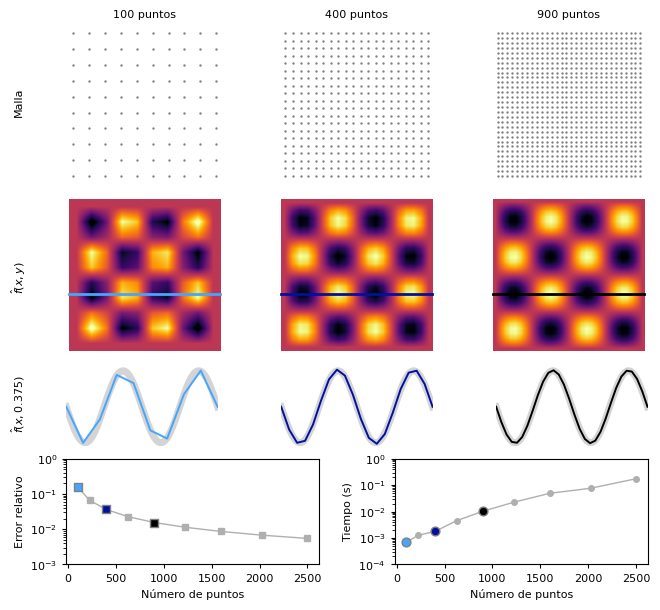

In [7]:
# Figure
fig = plt.figure(figsize=(7.5, 7.0))
outer_gs = GridSpec(4, 1, height_ratios=[0.6, 0.6, 0.30, 0.40],
                    figure=fig, hspace=0.1)

colors = ['#45A5FF', "#0010A1", "#000000"]
N_ejemplos = [10, 20, 30]

# === Row 1: Meshes ===
gs_mesh = outer_gs[0].subgridspec(1, 3, wspace=0.35)
for i, N in enumerate(N_ejemplos):
    ax = fig.add_subplot(gs_mesh[0, i])
    X, Y, _ = results[N]
    ax.scatter(X, Y, color='tab:gray', s=0.5)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")
    ax.set_title(f"{N*N} puntos", fontsize=8, pad=6)
fig.text(0.055, 0.77, r"Malla", fontsize=8, va="center", ha="left", rotation=90)

# Row 2: 2D contours
gs_superior = outer_gs[1].subgridspec(1, 3, wspace=0.35, hspace=0.00)
for i, (N, color) in enumerate(zip(N_ejemplos, colors)):
    ax = fig.add_subplot(gs_superior[0, i])
    X, Y, F = results[N]
    cf = ax.imshow(
        F.T,
        extent=(0, 1, 0, 1),
        cmap="inferno",
        vmin=-1,
        vmax=1,
        interpolation="bilinear",
        origin="lower",
    )

    y_linea = 0.375
    ax.plot(X[:, 0], np.full_like(X[:, 0], y_linea), color=color, lw=2, zorder=3)

    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

# Lateral annotation for contours
fig.text(0.05, 0.52, r"$\hat{f}(x,y)$", fontsize=8, va="center", ha="left", rotation=90)

# Row 3: 1D slices
gs_medio = outer_gs[2].subgridspec(1, 3, wspace=0.42, hspace=0.00)
for i, (N, color) in enumerate(zip(N_ejemplos, colors)):
    ax = fig.add_subplot(gs_medio[0, i])
    X, Y, F = results[N]
    idx_medio = np.argmin(np.abs(Y[0, :] - 0.375))
    x_linea = X[:, idx_medio]

    # Analytical solution (evaluated at 100 points)
    x_denso = np.linspace(0, 1, 100)
    y_denso = np.full_like(x_denso, 0.375)
    f_verdadero_denso = f_exact(x_denso, y_denso)
    ax.plot(x_denso, f_verdadero_denso, '-', color="#D4D4D4", lw=5.0, label="Analítica")

    # Numerical solution (PINN)
    ax.plot(x_linea, F[:, idx_medio], '-', color=color, lw=1.4, label="Numérica")

    # Limits and style
    ax.set_xlim(0, 1)
    ax.set_ylim(-1.1, 1.1)
    ax.axis("off")

# Lateral annotation for 1D slices
fig.text(0.05, 0.34, r"$\hat{f}(x,0.375)$", fontsize=8, va="center", ha="left", rotation=90)

# Row 4: Error and time
gs_inferior = outer_gs[3].subgridspec(1, 2, wspace=0.30, hspace=0.0)
ax_errN = fig.add_subplot(gs_inferior[0, 0])
ax_errT = fig.add_subplot(gs_inferior[0, 1])

# Error vs N² 
ax_errN.plot(np.array(N_values)**2, relative_errors, '-', lw=1, color='#AFAFAF',
             marker='s', markersize=4, label="Error relativo")  # línea + cuadrados
for N, color in zip(N_ejemplos, colors):
    idx = N_values.index(N)
    ax_errN.scatter(N_values[idx]**2, relative_errors[idx],
                    color=color, marker='s', s=40, edgecolor='gray', zorder=3)

ax_errN.set_xlabel('Número de puntos')
ax_errN.set_ylabel('Error relativo')
ax_errN.set_yscale('log')
ax_errN.set_ylim(top=1e0, bottom=1e-3)

# Time vs N²
ax_errT.plot(np.array(N_values)**2, times, '-', lw=1, color='#AFAFAF',
             marker='o', markersize=4, label="Tiempo")  # línea + círculos
for N, color in zip(N_ejemplos, colors):
    idx = N_values.index(N)
    ax_errT.scatter(N_values[idx]**2, times[idx],
                    color=color, marker='o', s=40, edgecolor='gray', zorder=3)

ax_errT.set_xlabel('Número de puntos')
ax_errT.set_ylabel('Tiempo (s)')
ax_errT.set_yscale('log')
ax_errT.set_ylim(top=1e0, bottom=1e-4)

# Save
plt.savefig("figs/01_helmholtz2D_convergence_esp.svg", dpi=150, bbox_inches='tight')
plt.savefig("figs/01_helmholtz2D_convergence_esp.pdf", dpi=150, bbox_inches='tight')
plt.show()
